# SageMaker End to End Solutions: Fraud Detection for Automobile Claims

<a id='overview-0'> </a>
## [Overview](./0-AutoClaimFraudDetection.ipynb)
* **[Notebook 0 : Overview, Architecture, and Data Exploration](./0-AutoClaimFraudDetection.ipynb)**
  * **[Business Problem](#business-problem)**
  * **[Technical Solution](#nb0-solution)**
  * **[Solution Components](#nb0-components)**
  * **[Solution Architecture](#nb0-architecture)**
  * **[DataSets and Exploratory Data Analysis](#nb0-data-explore)**
  * **[Exploratory Data Science and Operational ML workflows](#nb0-workflows)**
  * **[The ML Life Cycle: Detailed View](#nb0-ml-lifecycle)**
* [Notebook 1: Data Prep, Process, Store Features](./1-data-prep-e2e.ipynb)
  * Architecture
  * Getting started
  * DataSets
  * SageMaker Feature Store
  * Create train and test datasets
* [Notebook 2: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
  * Architecture
  * Train a model using XGBoost
  * Model lineage with artifacts and associations
  * Evaluate the model for bias with Clarify
  * Deposit Model and Lineage in SageMaker Model Registry
* [Notebook 3: Mitigate Bias, Train New Model, Store in Registry](./3-mitigate-bias-train-model2-registry-e2e.ipynb)
  * Architecture
  * Develop a second model
  * Analyze the Second Model for Bias
  * View Results of Clarify Bias Detection Job
  * Configure and Run Clarify Explainability Job
  * Create Model Package for second trained model
* [Notebook 4: Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)
  * Architecture
  * Deploy an approved model and Run Inference via Feature Store
  * Create a Predictor
  * Run  Predictions from Online FeatureStore
* [Notebook 5 : Create and Run an End-to-End Pipeline to Deploy the Model](./5-pipeline-e2e.ipynb)
  * Architecture
  * Create an Automated Pipeline
  * Clean up

## Overview, Architecture, and Data Exploration
본 노트북에서는 자동차 보험 사기, 기술 솔루션과 관련된 비즈니스 문제를 해결하고 데이터셋 및 솔루션 아키텍처를 탐색하고 머신 러닝 (ML) 수명주기 범위를 지정합니다.

<a id='business-problem'> </a>
## Business Problem
[overview](#overview-0)

<i> "자동차 보험 사기는 보험 신청에 대한 사실을 허위로 표현하고 보험 청구를 부풀리며 사고를 준비하고 한 번도 발생하지 않은 부상 또는 손상에 대한 청구 양식 제출, 도난 차량에 대한 허위 보고에 이르기까지 다양합니다.  IRC(Insurance Research Council)의 조사에 따르면, 보험 사기는 2012 년 자동차 보험 신체 상해에 대한 총 청구 금액의 15~17 %를 차지했습니다.
이 연구는 2012년에 자동차 보험 신체 상해 지불 청구액 중 56억 ~ 77억 달러가 사기로 판명되었다고 추정했으며, 이는 2002년의 43억 ~ 58억 달러 대비 크게 증가하였습니다.</i>" [source: Insurance Information Institute](https://www.iii.org/article/background-on-insurance-fraud)

본 예제에서는 자동차 보험 도메인을 사용하여 사기 가능성이 있는 청구를 감지합니다. 구체적으로 <i>"주어진 자동 청구가 사기 일 가능성은 무엇입니까?"</i> 의 유즈케이스를 다루며, 기술 솔루션을 탐색합니다.

ML 수명주기의 각 단계에서 제시된 [notebooks(노트북)](#nb0-notebooks) 및 [architectures(아키텍처)](#nb0-architecture)를 통해 데이터 과학자, 머신러닝 엔지니어 및 ML Ops 엔지니어들이 SageMaker 서비스 및 기능을 활용하여 효율성을 향상시킬 수 있는 방법을 알게 됩니다.

먼저, 고객 및 클레임에 대해 종합적으로 생성된 데이터셋에 대한 [테이터 탐색](#nb0-data-explore)을 수행합니다.<br>
그런 다음 [Solution Components(솔루션 구성 요소)](#nb0-components)와 [Solution Architecture(솔루션 아키텍처)](#nb0-architecture)를 검토하여 기술 솔루션에 대한 개요를 제공합니다. 

[detailed view of the Machine Learning Life-cycle](#nb0-ml-lifecycle), [separation of exploratory data science and operationalizing an ML worklfow](#nb0-workflows) 도 같이 참조해 주세요.

### Car Insurance Claims: Data Sets and Problem Domain

모델 및 워크플로를 구축하기 위한 입력은 보험 데이터의 두 테이블 인 클레임(cliams) 테이블과 고객(customers) 테이블입니다. 이 데이터는 SageMaker Data Wrangler로 전처리하기 위해 raw 데이터로 제공됩니다.하지만, 반드시 Data Wragnler 단계를 완료할 필요는 없습니다. 원한다면 Data Wragnler의 결과와 정확히 일치하는 `data` 디렉토리의 `claims_preprocessed.csv` 및 `customers_preprocessed.csv`를 사용할 수 있습니다.

<a id ='nb0-solution'> </a>
## Technical Solution
[overview](#overview-0)

본 세션에서는 사기 보험 청구를 예측하기 위한 솔루션을 구축하고 실시간 예측을 위해 SageMaker를 사용하여 배포하기 위한 기술 아키텍처 및 솔루션 구성 요소를 살펴 봅니다. 배포된 모델은 이 노트북 시리즈의 최종 결과물이지만이, 가이드의 목적은 [머신러닝 (ML) 수명주기](#ml-lifecycle)의 모든 세부 단계를 안내하고 SageMaker 서비스를 보여주기 위한 것입니다.

**Topics**
- [Solution Components](#nb0-components)
- [Solution Architecture](#nb0-architecture)
- [Code Resources](#nb0-code)
- [ML lifecycle details](#nb0-ml-lifecycle)
- [Manual/exploratory and automated workflows](#nb0-workflows) 

<a id ='nb0-components'> </a>
## Solution Components
[overview](#overview-0)
    
이 솔루션에서는 아래의 [SageMaker](https://sagemaker.readthedocs.io/en/stable/v2.html) 서비스들이 사용됩니다.

 1. [SageMaker DataWrangler](https://aws.amazon.com/sagemaker/data-wrangler/) - [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler.html)
 1. [SageMaker Processing](https://aws.amazon.com/blogs/aws/amazon-sagemaker-processing-fully-managed-data-processing-and-model-evaluation/) - [docs](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html)
 1. [SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/)- [docs](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_featurestore.html)
 1. [SageMaker Clarify](https://aws.amazon.com/sagemaker/clarify/)- [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-run.html)
 1. [SageMaker Training with XGBoost Algorithm and Hyperparameter Optimization](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/using_xgboost.html)- [docs](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/index.html)
 1. [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html)- [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-deploy.html#model-registry-deploy-api)
 1. [SageMaker Hosted Endpoints]()- [predictors - docs](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html)
 1. [SageMaker Pipelines]()- [docs](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/index.html)

![Solution Components](images/solution-components-e2e.png)

<a id ='nb0-data-explore'> </a>
## DataSets and Exploratory Visualizations
[overview](#overview-0)

데이터셋은 가상의 데이터로, <font color='green'> 고객 및 클레임</font> 데이터셋으로 구성됩니다.
먼저, 데이터를 로드하고 탐색적 시각화를 수행합니다.

In [2]:
!pip install seaborn

In [3]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

df_claims = pd.read_csv("./data/claims_preprocessed.csv", index_col=0)
df_customers = pd.read_csv("./data/customers_preprocessed.csv", index_col=0)

In [4]:
print(df_claims.isnull().sum().sum())
print(df_customers.isnull().sum().sum())

0
0


두 데이터셋 모두에서 null 값이 반환되지 않아야합니다.

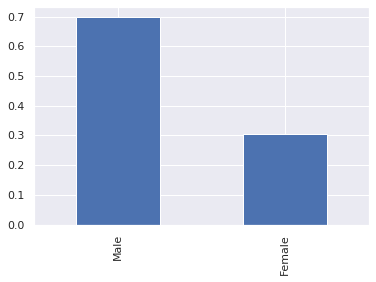

In [5]:
# plot the bar graph customer gender
df_customers.customer_gender_female.value_counts(normalize=True).plot.bar()
plt.xticks([0,1], ['Male', 'Female']);

남성 고객의 비중이 많음을 알 수 있습니다.

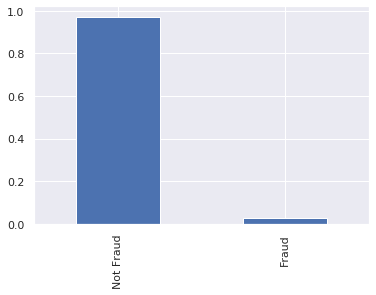

In [6]:
# plot the bar graph of fraudulent claims
df_claims.fraud.value_counts(normalize=True).plot.bar()
plt.xticks([0,1], ['Not Fraud', 'Fraud']);

대다수의 보험 청구는 합법적입니다. (즉, 사기가 아닙니다.)

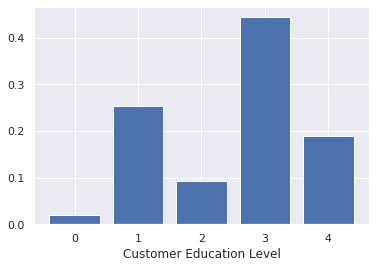

In [8]:
# plot the education categories
educ = df_customers.customer_education.value_counts(normalize=True, sort=False)
plt.bar(educ.index, educ.values)
plt.xlabel('Customer Education Level');

Text(0.5, 0, 'Total Claim Amount')

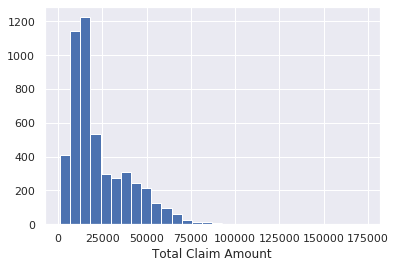

In [9]:
# plot the total claim amounts
plt.hist(df_claims.total_claim_amount, bins=30)
plt.xlabel('Total Claim Amount')

대다수의 보험 청구 금액은 $25,000 미만입니다.

In [10]:
print(df_customers.num_claims_past_year.describe())

count    5000.000000
mean        0.093000
std         0.422832
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: num_claims_past_year, dtype: float64


Text(0.5, 0, 'Number of claims per year')

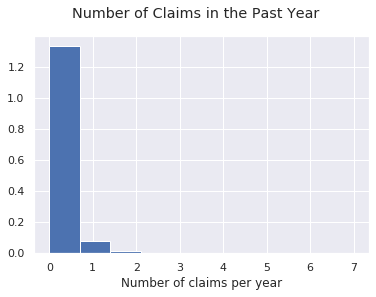

In [11]:
# plot the number of claims filed in the past year
df_customers.num_claims_past_year.hist(density=True)
plt.suptitle('Number of Claims in the Past Year')
plt.xlabel('Number of claims per year')

대부분의 고객은 전년도에 보험 청구를 하지 않았지만 일부 고객은 최대 7건의 보험 청구를 하였습니다.

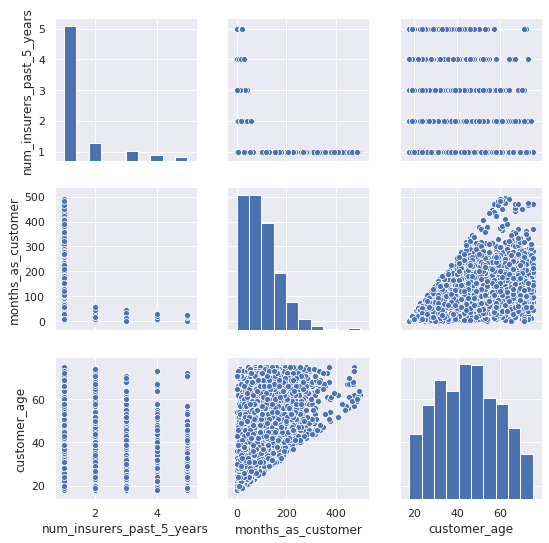

In [12]:
sns.pairplot(data = df_customers, vars=['num_insurers_past_5_years','months_as_customer','customer_age']);

당연히 `months_as_customer`와 `customer_age` 는 서로 연관되어 있습니다. 젊은 사람은 더 적은 시간 동안 운전을 했기 때문에 고객이 된 기간에 대한 잠재력이 더 적습니다.

또한 `num_insurers_past_5_years` 가 `months_as_customer` 와 음의 상관 관계가 있음을 알 수 있습니다. 누군가가 다른 보험사로 자주 뛰어 다니면 아마도이 보험사의 고객으로 보내는 시간이 줄어들었을 것입니다.

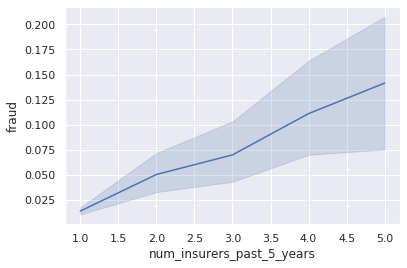

In [13]:
df_combined = df_customers.join(df_claims)
sns.lineplot(x='num_insurers_past_5_years', y='fraud', data=df_combined);

사기는 지난 5년 동안 더 많은 보험사에 가입한 것과 양의 상관 관계가 있습니다. 보험사를 더 자주 변경한 고객은 사기가 더 많이 발생했습니다.

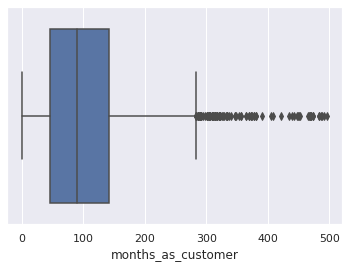

In [14]:
sns.boxplot(x=df_customers['months_as_customer']);

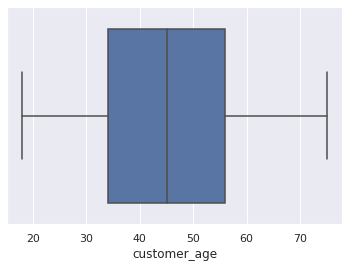

In [15]:
sns.boxplot(x=df_customers['customer_age']);

18세에서 75세까지 연령 분포를 보입니다.

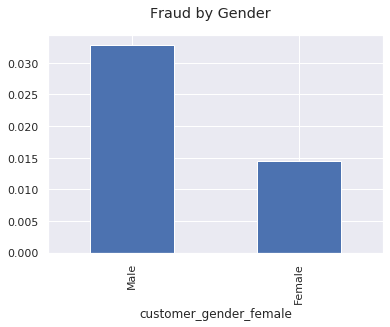

In [16]:
df_combined.groupby('customer_gender_female').mean()['fraud'].plot.bar()
plt.xticks([0,1], ['Male', 'Female'])
plt.suptitle('Fraud by Gender');

사기성 보험 청구는 남성 고객에게서 불균형적으로 발생합니다.

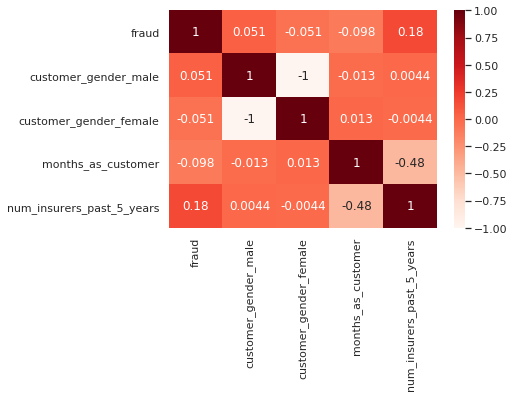

In [17]:
# Creating a correlation matrix of fraud, gender, months as customer, and number of different insurers
cols = ['fraud', 'customer_gender_male','customer_gender_female','months_as_customer', 'num_insurers_past_5_years']
corr = df_combined[cols].corr()

# plot the correlation matrix
sns.heatmap(corr, annot=True, cmap='Reds');

사기는 지난 5년 동안 더 많은 보험사에 가입한 것과 상관 관계가 있으며, 장기 가입 고객과 음의 상관 관계가 있습니다. 이는 장기간 고객이 사기를 저지를 가능성이 적다는 것을 의미합니다.


### Combined DataSets

개별 데이터셋을 살펴 보았으므로 이제 결합된 뷰(join)를 살펴 보겠습니다.

In [18]:
import pandas as pd
df_combined = pd.read_csv("./data/claims_customer.csv")

In [19]:
df_combined = df_combined.loc[:, ~df_combined.columns.str.contains('^Unnamed: 0')]
#get rid of an unwanted column
df_combined.head()

,policy_id,total_claim_amount,police_report_available,num_insurers_past_5_years,customer_gender_male,collision_type_na,incident_day,incident_hour,incident_month,driver_relationship_child,...,incident_type_theft,customer_age,policy_liability,collision_type_front,fraud,authorities_contacted_police,policy_state_nv,num_witnesses,incident_type_breakin,collision_type_rear
0,9,32168.0,1,2,1,0,30,9,8,0,...,0,35,3,1,0,1,0,1,0,0
1,3343,13600.0,1,1,0,0,28,6,8,0,...,0,43,1,0,0,1,0,2,0,1
2,1675,25347.0,1,1,0,0,2,4,3,0,...,0,61,1,1,0,1,0,5,0,0
3,35,45491.0,1,1,1,0,21,5,1,0,...,0,30,0,0,0,1,0,4,0,0
4,1692,23833.0,0,1,0,0,26,9,3,0,...,0,63,2,1,0,0,0,0,0,0


In [20]:
df_combined.describe()

,policy_id,total_claim_amount,police_report_available,num_insurers_past_5_years,customer_gender_male,collision_type_na,incident_day,incident_hour,incident_month,driver_relationship_child,...,incident_type_theft,customer_age,policy_liability,collision_type_front,fraud,authorities_contacted_police,policy_state_nv,num_witnesses,incident_type_breakin,collision_type_rear
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,41267.167400,0.421600,1.414000,0.456200,0.14560,15.560400,11.772400,6.726600,0.045200,...,0.048800,44.038000,1.115200,0.421800,0.032800,0.701800,0.044400,0.864600,0.096800,0.221000
std,1443.520003,32835.025055,0.493865,0.888123,0.498128,0.35274,8.775908,5.320062,3.630384,0.207763,...,0.215471,13.465809,0.984135,0.493896,0.178131,0.457514,0.206003,1.110186,0.295715,0.414962
min,1.000000,2100.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,...,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,22334.750000,0.000000,1.000000,0.000000,0.00000,8.000000,8.000000,3.000000,0.000000,...,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2500.500000,33080.000000,0.000000,1.000000,0.000000,0.00000,15.000000,12.000000,7.000000,0.000000,...,0.000000,44.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3750.250000,48959.500000,1.000000,1.000000,1.000000,0.00000,23.000000,16.000000,10.000000,0.000000,...,0.000000,54.000000,2.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000
max,5000.000000,588868.000000,1.000000,5.000000,1.000000,1.00000,31.000000,23.000000,12.000000,1.000000,...,1.000000,70.000000,3.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000


결합된 데이터셋에서 고유(unique), 결측치 또는 큰 비율의 범주를 살펴 보겠습니다.

In [21]:
combined_stats = []


for col in df_combined.columns:
    combined_stats.append((col, df_combined[col].nunique(), df_combined[col].isnull().sum() * 100 / df_combined.shape[0], df_combined[col].value_counts(normalize=True, dropna=False).values[0] * 100, df_combined[col].dtype))
    
stats_df = pd.DataFrame(combined_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_largest_category', 'datatype'])
stats_df.sort_values('percent_largest_category', ascending=False)

,feature,unique_values,percent_missing,percent_largest_category,datatype
34,policy_deductable,8,0.0,99.00,int64
24,policy_state_id,2,0.0,97.30,int64
12,authorities_contacted_fire,2,0.0,97.30,int64
18,authorities_contacted_ambulance,2,0.0,97.08,int64
41,fraud,2,0.0,96.72,int64
11,driver_relationship_other,2,0.0,96.00,int64
43,policy_state_nv,2,0.0,95.56,int64
9,driver_relationship_child,2,0.0,95.48,int64
37,incident_type_theft,2,0.0,95.12,int64
19,num_claims_past_year,7,0.0,93.30,int64


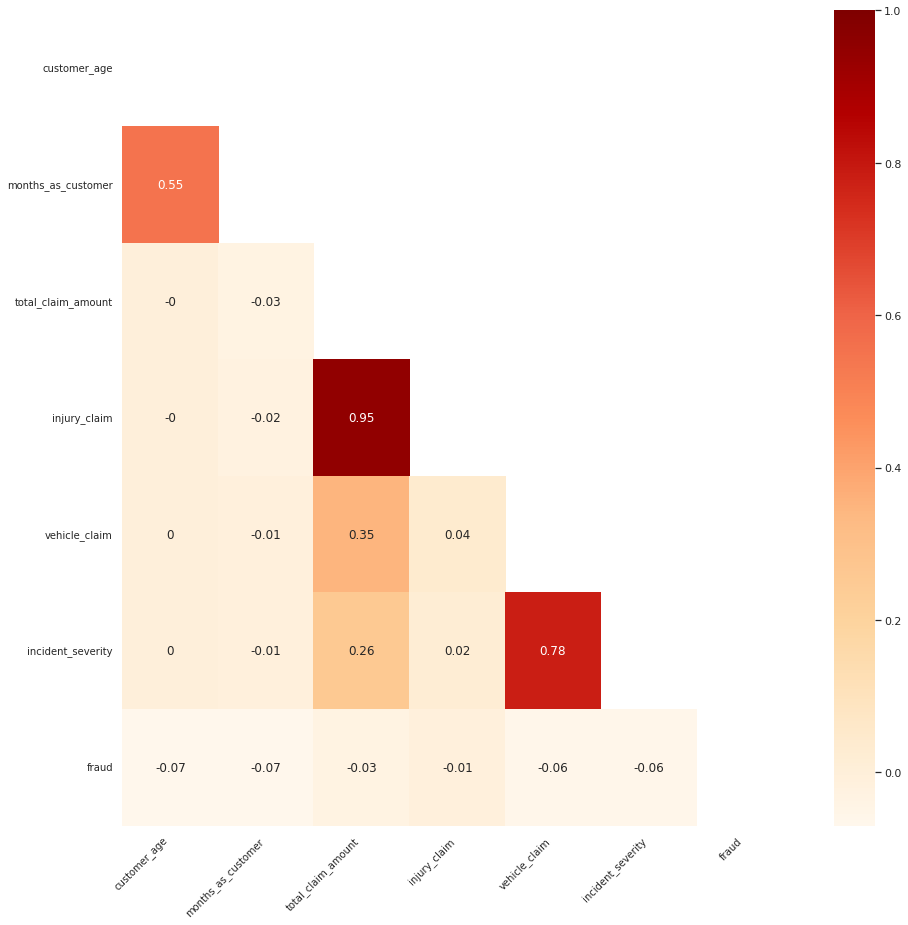

In [22]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('white')

corr_list=['customer_age','months_as_customer','total_claim_amount',
           'injury_claim','vehicle_claim',
           'incident_severity','fraud']

corr_df = df_combined[corr_list]
corr=round(corr_df.corr(),2)

fix, ax = plt.subplots(figsize=(15,15))

mask = np.zeros_like(corr, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='OrRd')

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha= 'right', rotation=45 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()

<a id ='nb0-architecture'> </a>
## Solution Architecture
[overview](#overview-0)

ML의 5단계를 거쳐 SageMaker의 솔루션 아키텍처를 살펴 보겠습니다. 

<a id ='nb0-data-prep'> </a>
### [Notebook 1](./1-data-prep-e2e.ipynb): Data Preparation, Ingest, Transform, Preprocess, and Store in SageMaker Feature Store
[overview](#nb0-solution)

![Solution Architecture](images/e2e-1-pipeline-v3b.png)



<a id ='nb0-train-store'> </a>
### [Notebook 2](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb) and [Notebook 3](./3-mitigate-bias-train-model2-registry-e2e.ipynb) :   Train, Tune, Check Pre- and Post- Training Bias, Mitigate Bias, Re-train, and Deposit the Best Model to SageMaker Model Registry
[overview](#nb0-solution)

![Solution Architecture](images/e2e-2-pipeline-v3b.png)

<a id ='nb0-deploy-predict'> </a>
### [Notebooks 4](./4-deploy-run-inference-e2e.ipynb) :   Load the Best Model from Registry, Deploy it to SageMaker Hosted Endpoint, and Make Predictions
[overview](#nb0-solution)

![Solution Architecture](images/e2e-3-pipeline-v3b.png)

<a id ='nb0-pipeline'> </a>
   ### [Notebooks 5](./5-pipeline-e2e.ipynb): End-to-End Pipeline - MLOps Pipeline to run an end-to-end automated workflow with all the design decisions made during manual/exploratory steps in previous notebooks.
[overview](#nb0-solution)   

![Notebook5 Pipelines](images/e2e-5-pipeline-v3b.png)

<a id ='nb0-code'> </a>
## Code Resources

[overview](#nb0-solution)

### Stages

본 솔루션은 [ML 수명주기(Lifecycle)](#nb0-ml-lifecycle)에 대한 여러 단계들로 구성되며, 각 단계에는 자체 [notebook]()이 있습니다.

* [Use-case and Architecture](./0-AutoClaimFraudDetection.ipynb): We take a high-level look at the use-case, solution components and architecture.
* [Data Prep and Store](./1-data-prep-e2e.ipynb): We prepare a dataset for machine learning using SageMaker DataWrangler, create and deposit the datasets in a SageMaker FeatureStore. [--> Architecture](#nb0-data-prep)
* [Train, Assess Bias, Establish Lineage, Register Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb): We detect possible pre-training and post-training bias, train and tune a XGBoost model using Amazon SageMaker, record Lineage in the Model Registry so we can later deploy it. [--> Architecture](#nb0-train-store)
* [Mitigate Bias, Re-train, Register New Model](./3-mitigate-bias-train-model2-registry-e2e.ipynb): We mitigate bias, retrain a less biased model, store it in a Model Registry.  [--> Architecture](#nb0-train-store)
* [Deploy and Serve](./4-deploy-run-inference-e2e.ipynb): We deploy the model to a Amazon SageMaker Hosted Endpoint and run realtime inference via the SageMaker Online Feature Store . [--> Architecture](#nb0-deploy-predict)
* [Create and Run an MLOps Pipeline](./5-pipeline-e2e.ipynb): We then create a SageMaker Pipeline that ties together everything we have done so far, from outputs from Data Wrangler, Feature Store, Clarify , Model Registry and finally deployment to a SageMaker Hosted Endpoint. [--> Architecture](#nb0-pipeline)
* [Conclusion](./6-conclusion-e2e.ipynb): We wrap things up and discuss how to clean up the solution.

<a id ='nb0-workflows'> </a>
## The Exploratory Data Science and ML Ops Workflows

[overview](#overview-0)

### Exploratory Data Science and Scalable MLOps

일반적으로 수동 탐색 워크플로와 자동화된 워크플로의 두 가지 워크플로가 있습니다.

탐색적 수동 데이터 과학 워크플로는 실험이 수행되고 다양한 기술과 전략이 테스트되는 곳입니다.

데이터 준비, 변환, 피쳐 전처리(featurizations) 및 훈련 알고리즘, 모델 튜닝을 위한 다양한 하이퍼 파라미터 테스트를 설정한 후 MLOps 또는 팀의 ML 엔지니어링 부분에 의존하여 프로세스를 간소화하는 자동화된 워크플로를 시작할 수 있습니다. 자동화된 파이프라인에 넣어 더 반복 가능하고 확장 가능합니다.

![the 2 flows](images/2-flows.png)

<a id ='nb0-ml-lifecycle'></a>
## The ML Life Cycle: Detailed View
[overview](#overview-0)

![title](images/ML-Lifecycle-v5.png)

빨간색 상자와 아이콘은 프로덕션 중심(연구 중심과 비교) 및 확장 가능한 ML 수명주기에서 포함하고 실행하는 것이 중요하다고 간주되는 비교적 새로운 개념과 작업을 나타냅니다.

이러한 최신 수명주기 작업과 이에 상응하는 지원 AWS 서비스 및 기능은 다음과 같습니다.

1. [*Data Wrangling*]() : 데이터 클린징, 정규화, 변환 및 인코딩은 물론 데이터셋 조인을 위한 AWS Data Wrangler입니다. 데이터 랭글러의 출력은 SageMaker Processing, SageMaker Pipelines, SageMaker Feature Store 또는 pandas가 있는 일반적인 Python 스크립트와 함께 작동하도록 생 된 코드입니다.
    1. 피쳐 엔지니어링은 항상 수행되었지만, 이제 AWS Data Wrangler를 통해 GUI 기반 도구를 사용하여 이를 수행하고 수명주기의 다음 단계를위한 코드를 생성할 수 있습니다.
2. [*Detect Bias*](): 데이터 준비 또는 훈련에서 AWS Clarify를 사용하여 사전 훈련 및 사후 훈련 편향을 감지할 수 있으며, 결국 추론 시간에 추론에 대한 해석 가능성 및 설명 가능성을 제공합니다 (예 : 예측)
3. [*Feature Store [Offline]*](): 모든 피쳐 엔지니어링, 인코딩 및 변환을 완료하면 AWS Feature Store에서 오프라인으로 피쳐를 표준화하여 모델 훈련을 위한 입력 피쳐로 사용할 수 있습니다.
4. [*Artifact Lineage*](): AWS SageMaker의 아티팩트 계보 기능을 사용하여 모든 아티팩트 (데이터, 모델, 매개 변수 등)를 훈련된 모델과 연결하여 모델 레지스트리에 저장할 수 있는 메타데이터를 생성할 수 있습니다.
5. [*Model Registry*](): AWS Model Registry는 모델 생성 프로세스에 포함하기로 선택한 모든 아티팩트 주변의 메타데이터를 모델 레지스트리에 모델 자체와 함께 저장합니다. 나중에 사람의 승인을 통해 모델이 프로덕션에 들어가는 것이 좋다는 것을 알 수 있습니다. 이는 배포 및 모니터링의 다음 단계로 넘어갑니다.
6. [*Inference and the Online Feature Store*](): 실시간 추론을 위해 생성한 온라인 AWS 피쳐 저장소를 활용하여 새로운 수신 데이터로 모델을 제공하기 위해 한 자릿수 밀리초(ms)의 낮은 지연 시간과 높은 처리량을 얻을 수 있습니다.
7. [*Pipelines*]():  수명주기의 다양한 옵션을 실험하고 결정한 후 (피쳐에 적용하기 위햔 변환, 데이터의 불균형 또는 편향, 훈련할 알고리즘 선택, 최고의 성능 메트릭을 제공하는 하이퍼 파라메터 등) 이제 SageMaker Pipelines를 사용하여 수명주기 전반에 걸쳐 다양한 작업을 자동화할 수 있습니다.
    1. 이 핸즈온에서는 AWS Data Wrangler의 출력으로 시작하여 훈련된 모델을 모델 레지스트리에 저장하는 것으로 끝나는 파이프 라인을 보여줍니다.
    2. 일반적으로 데이터 준비를 위한 파이프라인, 모델 레지스트리까지 훈련용 파이프라인, 추론용 파이프라인, 모델 드리프트 및 데이터를 감지하기 위해 SageMaker Monitor를 사용한 재훈련용 파이프 라인이 있을 수 있습니다. AWS Lambda 함수를 사용하여 드리프트하고 재훈련을 트리거합니다.

[overview](#overview-0)

___

### Next Notebook: [Data Preparation, Process, and Store Features](./1-data-prep-e2e.ipynb)